In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy zip file to local Colab storage
!cp "/content/drive/My Drive/cell_images.zip" "/content/"

# Extract in local storage (much faster)
!unzip -q "/content/cell_images.zip" -d "/content/extracted_data/"



Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [3]:
data_path = 'extracted_data/cell_images'  # should contain 'Parasitized/' and 'Uninfected/'

print("Classes:", os.listdir(data_path))
print("Parasitized samples:", len(os.listdir(os.path.join(data_path, 'Parasitized'))))
print("Uninfected samples:", len(os.listdir(os.path.join(data_path, 'Uninfected'))))


Classes: ['cell_images', 'Parasitized', 'Uninfected']
Parasitized samples: 13780
Uninfected samples: 13780


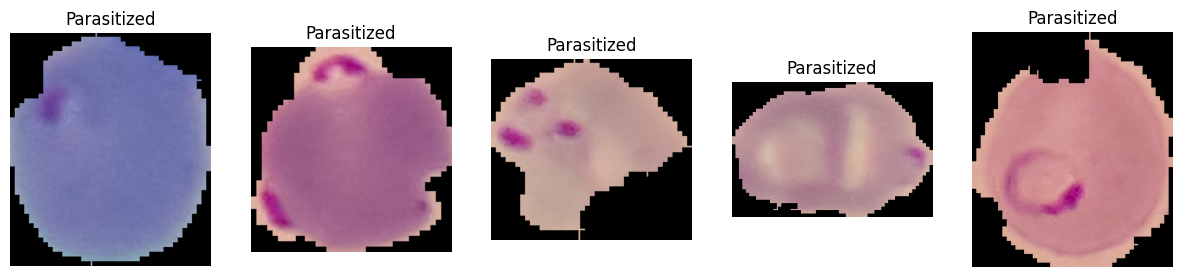

In [4]:
img_path = os.path.join(data_path, 'Parasitized')
sample_imgs = random.sample(os.listdir(img_path), 5)

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(sample_imgs):
    img = cv2.imread(os.path.join(img_path, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Parasitized')
plt.show()


In [5]:
from tqdm import tqdm

IMG_SIZE = 64

def load_data():
    X = []
    y = []
    for label, category in enumerate(['Parasitized', 'Uninfected']):
        folder_path = os.path.join(data_path, category)
        for img_name in tqdm(os.listdir(folder_path)[:3000]):  # Load ~3000 per class for speed
            img_path = os.path.join(folder_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(label)
            except:
                continue
    return np.array(X), np.array(y)

X, y = load_data()


100%|██████████| 3000/3000 [00:03<00:00, 984.11it/s]


In [6]:
from sklearn.model_selection import train_test_split

X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.5747 - loss: 0.6786 - val_accuracy: 0.6833 - val_loss: 0.5987
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - accuracy: 0.6775 - loss: 0.6104 - val_accuracy: 0.7479 - val_loss: 0.5775
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.7520 - loss: 0.5230 - val_accuracy: 0.8146 - val_loss: 0.4306
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.8564 - loss: 0.3658 - val_accuracy: 0.8677 - val_loss: 0.3253
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - accuracy: 0.9123 - loss: 0.2530 - val_accuracy: 0.8958 - val_loss: 0.2653
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.9322 - loss: 0.1870 - val_accuracy: 0.8979 - val_loss: 0.2477
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.9445 - loss: 0.1628 - val_accuracy: 0.9104 - val_loss: 0.2534
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.9534 - loss: 0

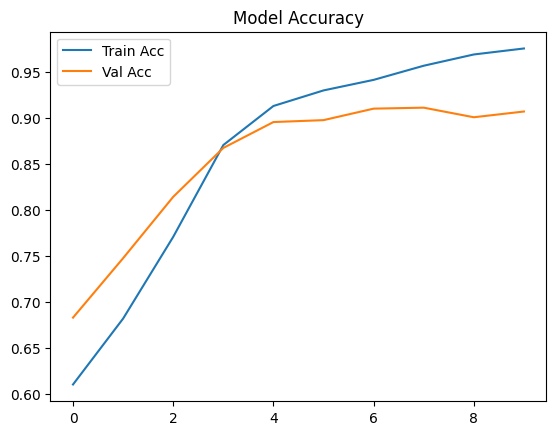

In [9]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()


In [10]:
model.save("malaria_model.h5")
